# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Based on Yandex School of Data Analysis Practical RL course.

In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install gymnasium==0.29.1
%pip install gymnasium[atari]==0.29.1
%pip install atari-py
%pip install autorom
%pip install autorom[accept-rom-license]


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: DISPLAY=:1


/bin/bash: ../xvfb: No such file or directory


In [4]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [6]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2
from gymnasium.core import ObservationWrapper
from gymnasium.spaces import Box

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (1, self.img_size[0], self.img_size[1]))

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * Crop image, remove irrelevant parts.
        #  * Resize image to self.img_size. Use cv2.resize or any other library you want,
        #    e.g. PIL or Keras. Do not use skimage.transform.resize because it is roughly
        #    6x slower than cv2.resize.
        #  * Cast image to grayscale.
        #  * Convert image pixels to (0, 1) range, float32 type.
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255
        img = cv2.resize(img, self.img_size)
        img = np.expand_dims(img, axis=0)

        return img.astype(np.float32)
    
    


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [19]:
from gymnasium.spaces.box import Box
from gymnasium.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset()[0])
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info, _ = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [22]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
state = env.reset()

In [23]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, _state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = _state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    @staticmethod
    def _softmax(x: np.ndarray) -> np.ndarray:
        return np.exp(x) / np.exp(x).sum()

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        _states = self.new_state_memory[batch]
        done = self.terminal_memory[batch]

        return states, actions, rewards, _states, done

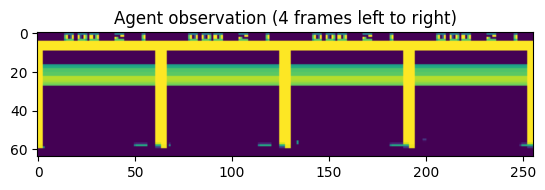

In [27]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
# plt.imshow(env.render("rgb_array"))
# plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(np.c_[obs[0], obs[1], obs[2], obs[3]])

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

In [24]:
class DQN(nn.Module):
    def __init__(self, lr, state_shape, n_actions):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(state_shape[0], 16, 3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2)
        # self.conv4 = nn.Conv2d(128, 256, 1, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3136, 256)
        self.fc2 = nn.Linear(256, 512)
        self.output = nn.Linear(512, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0') if T.cuda.is_available() else T.device('cpu')
        self.to(self.device)

    def forward(self, state):
        state = F.relu(self.conv1(state))
        state = F.relu(self.conv2(state))
        state = F.relu(self.conv3(state))
        # state = F.relu(self.conv4(state))
        state = self.flatten(state)
        # print(f'after conv: {state.shape}')

        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        actions = self.output(state)

        return actions

In [30]:
class DDQNAgent:
    def __init__(self, state_size, action_size, learning_rate, update_rate=500):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(50_000, state_size)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.005
        self.network_sync_rate = update_rate
        self.update_cntr = 0
        self.q = DQN(learning_rate, state_size, action_size)
        self.q_target = DQN(learning_rate, state_size, action_size)
        self.update_weights()
        self.evaluate=False

    def store_transition(self, state, action, reward, _state, done):
        self.memory.store_transition(state, action, reward, _state, done)

    def choose_action(self, state):
        if np.random.random() <= self.epsilon and not self.evaluate:
            action = np.random.choice(self.action_size)
        else:
            state = T.tensor(state).to(self.q.device)
            actions = self.q.forward(state)
            action = T.argmax(actions).item()

        return action

    def get_best_action(self, state):
        state = T.tensor(state).to(self.q.device)
        actions = self.q.forward(state)
        action = T.argmax(actions).item()

        return action

    def learn(self, batch_size):
        if self.memory.mem_cntr < batch_size:
            return

        states, actions, rewards, _states, done = self.memory.sample_buffer(batch_size)

        states = T.tensor(states).to(self.q.device)
        _states = T.tensor(_states).to(self.q_target.device)

        q_test = self.q(states)
        with T.no_grad():
            q_next = self.q_target.forward(_states).cpu().detach().numpy()
            q_target = q_test.cpu().detach().numpy().copy()

            max_actions = np.argmax(q_next, axis=1)

            batch_index = np.arange(batch_size, dtype=np.int32)

            q_target[batch_index, actions] = rewards + self.gamma * q_next[batch_index, max_actions] * (1-done)
            q_target = T.tensor(q_target).to(self.q.device)

        q_pred = self.q(states)
        self.q.optimizer.zero_grad()
        loss = self.q.loss(q_pred, q_target).to(self.q.device)
        loss.backward()
        self.q.optimizer.step()

    def update_epsilon_value(self):
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon_min

    def update_weights(self):
        self.q_target.load_state_dict(self.q.state_dict())

Now let's try out our agent to see if it raises any errors.

In [35]:
def play_and_record(agent, env, n_steps=1):
    state = env.framebuffer
    cum_reward = 0

    for n in range(n_steps):
        state = np.expand_dims(state, axis=0)
        action = agent.choose_action(state)
        _state, reward, terminal, _ = env.step(action)
        cum_reward += reward

        agent.store_transition(state, action, reward, _state, terminal)
        state = _state

        if terminal:
            state = env.reset()

    return cum_reward

In [36]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        state = env.reset()
        reward = 0
        for _ in range(t_max):
            state = np.expand_dims(state, axis=0)
            action = agent.get_best_action(state) if greedy else agent.choose_action(state)
            state, r, done, _ = env.step(action)
            reward += r
            if done:
                break
                
        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
EPOCHS = 100_000
BATCH_SIZE = 64

agent = DDQNAgent(env.observation_space.shape, env.action_space.n, learning_rate=1e-3)

In [46]:
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

mean_rw_history = []
epsilons = []

epsilon = 0.74500
epoch 24600: mean reward = 0.667


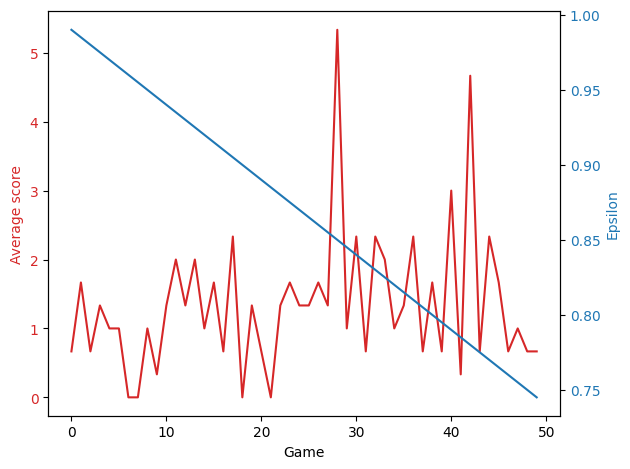

 25%|██▍       | 24662/100000 [26:34<1:11:14, 17.62it/s]

In [ ]:
progress_bar = tqdm(range(EPOCHS))
for i in progress_bar:
    
    # play
    play_and_record(agent, env, 10)
    
    # train
    agent.learn(BATCH_SIZE)
    
    # adjust agent parameters
    if i % 500 == 0:
        agent.update_weights()
        agent.update_epsilon_value()
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        epsilons.append(agent.epsilon)

    if i % 100 == 0:
        clear_output(True)
        print("epsilon = %.5f" % agent.epsilon)
        print(f'epoch {i}: mean reward = {mean_rw_history[-1]:.3f}')

        # plt.title("mean reward per game")

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Game')
        ax1.set_ylabel('Average score', color=color)
        ax1.plot(mean_rw_history, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Epsilon', color=color)  # we already handled the x-label with ax1
        ax2.plot(epsilons, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

In [ ]:
eval = evaluate(make_env(), agent, n_games=10)

In [42]:
print(f'Average score: {eval}')

Average score: 1.0
